In [1]:
# N = N_up + N_down fermions in a harmonic trap, with delta function interaction

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
os.environ["JAX_ENABLE_X64"]="True"

import numpy as np
import time
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import tqdm, trange
from math import factorial
import pickle
import csv

# set the default device to the cpu
jax.default_device(jax.devices("cpu")[0])
jax.config.update('jax_platform_name', 'cpu')

#use pickle to save the parameters to a file 
def save_params(params, filename):
    with open(filename, 'wb') as f:
        pickle.dump(params, f)
# use pickle to dump the energies and uncertainties to a file
def save_energies(hs, us, filename):
    with open(filename, 'wb') as f:
        pickle.dump((hs, us), f)

def save_energies(h, u, filename):
    with open(filename,'a') as file:
        file.write(str(h)+","+str(u))
        file.write('\n')

# use pickle to load the parameters from a file
def load_params(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)    
# use pickle to load the energies and uncertainties from a file
def load_energies(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# using this data:
# 1, 0.0854344122657581
# 2, 0.12291311754684836
# 3, 0.15085178875638838
# 4, 0.1753833049403748
# 5, 0.1965076660988075
# 6, 0.21626916524701872
# 7, 0.23330494037478702
# 8, 0.2503407155025553
# 9, 0.2656729131175468

def compute_true_energy():
    ret = (N_up**2 + N_down**2)/2 
    if N_up == 1: 
        ret += 0.0854344122657581
    elif N_up == 2:
        ret += 0.12291311754684836
    elif N_up == 3:
        ret += 0.15085178875638838
    elif N_up == 4:
        ret += 0.1753833049403748
    elif N_up == 5:
        ret += 0.1965076660988075
    elif N_up == 6:
        ret += 0.21626916524701872
    elif N_up == 7:
        ret += 0.23330494037478702
    elif N_up == 8:
        ret += 0.2503407155025553
    elif N_up == 9:
        ret += 0.2656729131175468
    return ret


##### Constants
N_up = 4
N_down = 4
N = N_up + N_down

FACT_UP = 2 #increase this when N goes up
FACT_DOWN = 2 # increase this when N goes up
SYM_DEN = 5
GPU_INDEX = 1
# division factor in the ansatz
DIV = 2
INITIAL_SAMPLE = jnp.array(np.random.uniform(-2, 2, N))
phi_structure = [150,150]

m = 1
hbar = 1
omega = 1
harmonic_omega = 1
g = 0

PARAM_PREFIX = "5+5/large_g_150_params_g_"


#######

# this just gets the shapes of the weights and biases for a neural network with the given structure
def gen_weight_shapes(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
        w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
        b = np.random.randn(1, sizes[i+1]) 
        weights.append(w)
        biases.append(b) 
    return weights, biases

# get the shapes
weight_shapes, bias_shapes = gen_weight_shapes(N, phi_structure, 1)

# generates a set of weights and biases for a neural network with the given structure
# returns a flattened array of the parameters

def gen_params(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            weights.append(w)
            biases.append(b)
    return flatten_params(weights, biases) 

# calls the neural network with the given parameters and input
@jit
def nn(x, params):
    weights, biases = unflatten_params(params) 
    a = x
    for i in range(len(weights) - 1):
        z = jnp.dot(a, weights[i]) + biases[i]
        a = celu(z)
    a = jnp.dot(a, weights[-1]) + biases[-1]
    return a[0][0] 

# takes the weights and biases of a network and returns a flattened array of the parameters
@jit
def flatten_params(weights, biases):
    params = jnp.array([])
    for i in range(len(weights)):
        params = jnp.concatenate((params, weights[i].flatten()))
        params = jnp.concatenate((params, biases[i].flatten()))
    return jnp.array(params)

# takes a flattened array of parameters and returns the weights and biases of the network
@jit
def unflatten_params(params):
    weights = []
    biases = []
    start = 0
    for i in range(len(weight_shapes)):
        end = start + weight_shapes[i].size 
        weights.append(jnp.reshape(jnp.array(params[start:end]), weight_shapes[i].shape))
        start = end
        end = start + bias_shapes[i].size
        biases.append(jnp.reshape(jnp.array(params[start:end]), bias_shapes[i].shape))
        start = end
    return weights, biases



network = gen_params(N, phi_structure, 1)
# the length of the flattened parameters of a single particle neural network
phi_params_length = len(network)

# function that takes the coords, and moves coords[index] to the front of the list
@partial(jit, static_argnums=(1,))
def shift_coords(coords, index):
    return jnp.concatenate([jnp.array([coords[index]]), jnp.array(coords[:index]), jnp.array(coords[index + 1:])])

@partial(jit, static_argnums=(1,))
def inputs_up(coords, j):
    reordered = shift_coords(coords, j)
    sym_piece1 = reordered[1:N_up]
    sym_piece2 = reordered[N_up:]

    new1 = []
    new2 = []
    for i in range(1, N_up):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down+1):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
    
    return jnp.array([reordered[0]] + new1 + new2)

@partial(jit, static_argnums=(1,))
def inputs_down(coords, j):
    reordered = shift_coords(coords, j + N_up)
    
    sym_piece1 = reordered[1:N_up+1]
    sym_piece2 = reordered[N_up + 1:]
    
    new1 = []
    new2 = []
    for i in range(1, N_up+1):
        new1.append(sum((jnp.array(sym_piece1)/SYM_DEN)**i))
    for i in range(1, N_down):
        new2.append(sum((jnp.array(sym_piece2)/SYM_DEN)**i))
        
    return jnp.array([reordered[0]] + new1 + new2)

@jit
def Phi_up(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_up, N_up))
    for i in range(N_up):
        ith_params = params[i * phi_params_length : (i + 1) * phi_params_length]
        for j in range(N_up): 
            mat = mat.at[i,j].set(nn(inputs_up(coords, j), ith_params))
    return jnp.linalg.det(mat) * FACT_UP 

@jit
def Phi_down(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_down, N_down))
    for i in range(N_down):
        temp = i + N_up
        ith_params = params[temp * phi_params_length : (temp + 1) * phi_params_length]
        for j in range(N_down): 
            mat = mat.at[i,j].set(nn(inputs_down(coords, j), ith_params))
    return jnp.linalg.det(mat)* FACT_DOWN

@jit
def psi(coords, params):
    return Phi_up(coords, params) * Phi_down(coords, params) * jnp.exp(-omega * jnp.sum((coords/DIV)**2))


@jit
def mcstep_E(xis, limit, positions, params):
    
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    newpositions = jnp.array(positions) + xis
    
    # prob = psi(newpositions, params)**2./psi(positions, params)**2.
    prob = (psi(newpositions, params)/psi(positions, params))**2.
    
    def truefunc(p):
        return [newpositions, True]

    def falsefunc(p):
        return [positions, False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)

def sample(params, Nsweeps, Ntherm, keep, stepsize, positions_initial=INITIAL_SAMPLE, progress=False):
    sq = []
    sq_prime = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 
    params = jax.device_put(params, device=jax.devices("cpu")[0])

    randoms = np.random.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = np.random.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in tqdm(range(0, num_total), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
    # generate the primed samples by going through every sample and making sample[N_up] = sample[0]
    sq_prime = sq.copy()
    for i in range(len(sq)):
        a = np.array(sq[i])
        a[N_up] = a[0]
        sq_prime[i] = jnp.array(a) 

    return jnp.array(sq), jnp.array(sq_prime), counter/num_total


psi_hessian = jax.jacfwd(jit(grad(psi, 0)), 0) # type: ignore

@jit
def ddpsi(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(psi_hessian(coords, params))


# derivative of the wavefunction with respect to the parameters
dnn_dtheta = jit(grad(psi, 1)) 
vdnn_dtheta = jit(vmap(dnn_dtheta, in_axes=(0, None), out_axes=0))


@jit
def Es_nodelta(coords, params):
    return - (1/2) * (1/ psi(coords, params)) * jnp.sum(ddpsi(coords, params)) + (1/2) * jnp.sum(coords**2) 

vEs_nodelta = jit(vmap(Es_nodelta, in_axes=(0,None), out_axes=0))

@jit
def Es_delta(coords, coords_prime, params, alpha, g):
    return N_up * N_down * g * (psi(coords_prime, params)**2)/(psi(coords, params)**2) * (1/(np.sqrt(np.pi)*alpha))*np.e**(-(coords[N_up]/alpha)**2)

vEs_delta = jit(vmap(Es_delta, in_axes=(0,0, None, None, None), out_axes=0))

@jit
def gradient_comp(coords, coords_prime, params, es_nodelta, energy_calc, es_delta):
    return 2/(psi(coords,params)) * dnn_dtheta(coords, params) * (es_nodelta - energy_calc) + 2/(psi(coords_prime, params)) * dnn_dtheta(coords_prime, params) * es_delta

vgradient_comp = jit(vmap(gradient_comp, in_axes=(0,0,None,0, None, 0), out_axes=0))

def gradient(params, g, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # first sample
    params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    samples, samples_prime, _ = sample(params, num_samples, thermal, skip, variation_size)
    ys = jnp.array(samples_prime[:, N_up]) 
    alpha = np.sqrt(np.max(abs(np.array(ys)))**2/(-np.log(np.sqrt(np.pi)*(10**-10))))

    e_nodeltas = vEs_nodelta(samples, params)
    e_deltas = vEs_delta(samples, samples_prime, params, alpha, g)

    e_term = e_nodeltas + e_deltas
    energy_calc = jnp.mean(e_term)

    # compute the uncertainty in the energy
    uncert = jnp.std(e_term)/jnp.sqrt(num_samples) 
    # gradient computation
    grads = vgradient_comp(samples, samples_prime, params, e_nodeltas, energy_calc, e_deltas)
    gradient_calc = jnp.mean(grads, axis=0) 
    return gradient_calc, energy_calc, uncert


def step(params_arg, step_num, N, thermal, skip, variation_size, g):
        gr = gradient(params_arg, g, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size, g):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size, g)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        # save the energies and uncertainties to a file
#         save_energies(hs, us, "energies.pkl")
        save_energies(energy, uncert, "4+4_energies.csv")
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params



In [2]:
def find_step_size(params, start):
    lr = .1
    target = 0.5
    tolerance = .1
    max_it = 1000
    step = start
    best_step = start
    best_acc = 0
    it_num = 0
    last = start
    # get the samples 
    _, _, acc = sample(params, 1000, 100, 5, step)
    # while the acceptance rate is not within +/- .5 of the target
    while (acc < target - tolerance or acc > target + tolerance) and it_num < max_it:
        print(best_step)
        it_num += 1
        last = step
        # if the acceptance rate is too low, increase the step size
        if acc < target - tolerance:
            step -= lr
        # if the acceptance rate is too high, decrease the step size
        elif acc > target + tolerance:
            step += lr
        # if we cross the target, decrease the learning rate and go back
        if (acc < target and best_acc > target) or (acc > target and best_acc < target):
            lr /= 2
            step = best_step
        # keep track of the best step size
        if abs(acc - target) < abs(best_acc - target):
            best_acc = acc
            best_step = step

        if last == step:
            break 
        # get the samples for the next step size
        _, _, acc = sample(params, 1000, 100, 5, step)
    print(best_step)
    return best_step

In [3]:
print(compute_true_energy())
# clear the energies.pkl file
open("4+4_energies.csv", 'w').close()

16.175383304940375


In [4]:
# make N sets of parameters
params = gen_params(N, phi_structure, 1)
for i in range(N - 1):
    params = jnp.concatenate((params, gen_params(N, phi_structure, 1)))
print(len(params))

193208


In [5]:
step_size = .3
samples = sample(params, 1000, 100, 5, step_size, progress=True)
print(samples[2])

MC: 100%|██████████| 5101/5101 [00:08<00:00, 570.87it/s] 


0.49754950009802


In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(10 ** (-3))

g=0
# first find the step size
step_size = .3
resultsa = train(params, 250, 100, 100, 5, step_size, g)
resultsb = train(resultsa[3], 1000,400,100,10, find_step_size(params,step_size), g)
resultsc = train(resultsb[3], 500,1600,100,10, find_step_size(params,step_size), g)
resultsd = train(resultsc[3], 20,40000,100,10, find_step_size(params,step_size), g)

# save the parameters to a file
# save_params(resultsd[3], PARAM_PREFIX + str(g) + ".pkl")
save_params(resultsd[3], "4+4_g_0.pkl")
results_0 = resultsd[3]

In [ ]:
g = -.5
resultsa = train(params, 20, 10000, 100, 10, find_step_size(params,step_size), g)


In [ ]:
resultsb = train(resultsa[3], 100, 20000,1000,10, find_step_size(resultsa[3],step_size), g)
resultsc = train(resultsb[3], 50, 50000,1000,10, find_step_size(resultsb[3],step_size), g)

# save the parameters to a file
# save_params(resultsc[3], PARAM_PREFIX + str(g) + ".pkl")
save_params(resultsc[3], "4+4_g_-05.pkl")

results_neg_05 = resultsc[3]

In [ ]:
g = -1
resultsa = train(results_neg_05, 1000, 800, 100, 10, find_step_size(params,step_size), g)
resultsb = train(resultsa[3], 500,1600,100,10, find_step_size(params,step_size), g)
resultsc = train(resultsb[3], 20, 50000,100,10, find_step_size(params,step_size), g)

# save the parameters to a file
# save_params(resultsc[3], PARAM_PREFIX + str(g) + ".pkl")
save_params(resultsd[3], "4+4_g_-1.pkl")


results_neg_1 = resultsc[3]

In [ ]:
g = -1.5
resultsa = train(results_neg_1, 1000, 800, 100, 10, find_step_size(params,step_size), g)
resultsb = train(resultsa[3], 500,1600,100,10, find_step_size(params,step_size), g)
resultsc = train(resultsb[3], 20, 50000,100,10, find_step_size(params,step_size), g)

# save the parameters to a file
# save_params(resultsc[3], PARAM_PREFIX + str(g) + ".pkl")
save_params(resultsd[3], "4+4_g_-15.pkl")

results_neg_15 = resultsc[3]

In [17]:
# density profiles for the 4+4 cases
def local_density(samples):
    all_xs = samples[0][:,0]
    x_min = np.min(all_xs)
    x_max = np.max(all_xs)
    
    x_bins = np.linspace(x_min - 1.5, x_max + 1.5, 100)
    dx = x_bins[1] - x_bins[0]  # Bin width
    n_x = np.zeros_like(x_bins)

    # bin the x_1s
    for x in samples[0][:,0]:
        n_x[np.digitize(x, x_bins)] += 1

    # Normalize
    n_x /= (dx * np.sum(n_x))

    return x_bins, n_x

In [7]:
# load the parameters
params_0 = load_params("4+4/4+4_g_0_PRECISE.pkl")
params_neg_05 = load_params("4+4/4+4_g_-.5_PRECISE.pkl")
params_neg_1 = load_params("4+4/4+4_g_-1_PRECISE.pkl")
params_neg_15 = load_params("4+4/4+4_g_-1.5_PRECISE.pkl")

In [8]:
samples_0 = sample(params_0, 50000, 100, 10, find_step_size(params_0, .3), progress=True)

0.3


MC: 100%|██████████| 500101/500101 [07:25<00:00, 1122.81it/s]


In [9]:
samples_neg_05 = sample(params_neg_05, 50000, 100, 10, find_step_size(params_neg_05, .3), progress=True)

0.3


MC: 100%|██████████| 500101/500101 [07:30<00:00, 1109.81it/s]


In [10]:
samples_neg_1 = sample(params_neg_1, 50000, 100, 10, find_step_size(params_neg_1, .3), progress=True)

0.3


MC: 100%|██████████| 500101/500101 [07:18<00:00, 1140.47it/s]


In [11]:
samples_neg_15 = sample(params_neg_15, 50000, 100, 10, find_step_size(params_neg_15, .3), progress=True)

0.3


MC: 100%|██████████| 500101/500101 [07:41<00:00, 1084.76it/s]


In [18]:
x_bins_0, n_x_0 = local_density(samples_0)
x_bins_05, n_x_05 = local_density(samples_neg_05)
x_bins_1, n_x_1 = local_density(samples_neg_1)
x_bins_15, n_x_15 = local_density(samples_neg_15)


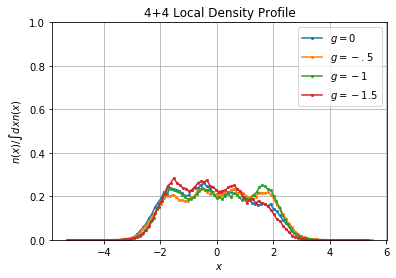

In [19]:
plt.plot(x_bins_0, n_x_0,'-o', markersize=2,label=r"$g=0$")
plt.plot(x_bins_05, n_x_05,'-o', markersize=2,label=r"$g=-.5$")
plt.plot(x_bins_1, n_x_1,'-o', markersize=2,label=r"$g=-1$")
plt.plot(x_bins_15, n_x_15,'-o', markersize=2,label=r"$g=-1.5$")
plt.title(r"4+4 Local Density Profile")
plt.xlabel("$x$")
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.ylabel("$n(x)/\int dx n(x)$")
plt.show()